# Malaria Classification - Image Classification

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

## Preparing the data

In [2]:
dataset, dataset_set = tfds.load('malaria', split=['train'], as_supervised=True, shuffle_files=True, with_info=True)

In [3]:
for data in dataset[0].take(4):
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [4]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.1
VAL_RATIO = 0.1

In [5]:
DATASET_SIZE = len(dataset[0])

train_dataset = dataset[0].take(int(TRAIN_RATIO*DATASET_SIZE))

val_dataset = dataset[0].skip(int(TRAIN_RATIO*DATASET_SIZE)) # skips upto 80%
val_dataset = val_dataset.take(int(VAL_RATIO*DATASET_SIZE)) # then takes the 10% of the remaining 20% as validation dataset

test_dataset = dataset[0].skip(int((TRAIN_RATIO+VAL_RATIO)*DATASET_SIZE)) # skips upto 90%
test_dataset = test_dataset.take(int(TEST_RATIO*DATASET_SIZE)) # then takes the 10% as test data

In [6]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

22046
2755
2755


In [7]:
print(list(train_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)]


## Visualising the Dataset

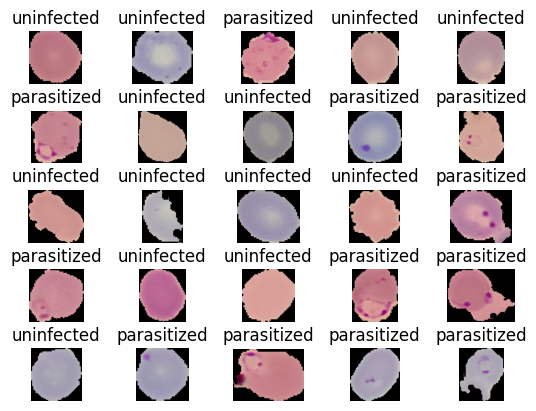

In [8]:
fig = plt.figure()

for i, (image, label) in enumerate(train_dataset.take(25)):
  plt.subplot(5,5, i+1)
  plt.imshow(image)
  plt.title(dataset_set.features['label'].int2str(label))
  plt.axis('off')

# Adjust the space between the plots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

## Data Preprocessing

Normalisation
$$X = \frac{X - X(min)}{X(max) - X(min)}$$

i.e

$$
  X = \frac{X - 0}{255-0}\\
  X = \frac{X}{255}
$$



In [9]:
IMAGE_SIZE = 224

def resizing_rescaling(image, label):
  return tf.image.resize(image, (IMAGE_SIZE,IMAGE_SIZE))/255, label

In [10]:
train_dataset = train_dataset.map(resizing_rescaling)

In [11]:
test_dataset = test_dataset.map(resizing_rescaling)

In [12]:
val_dataset = val_dataset.map(resizing_rescaling)

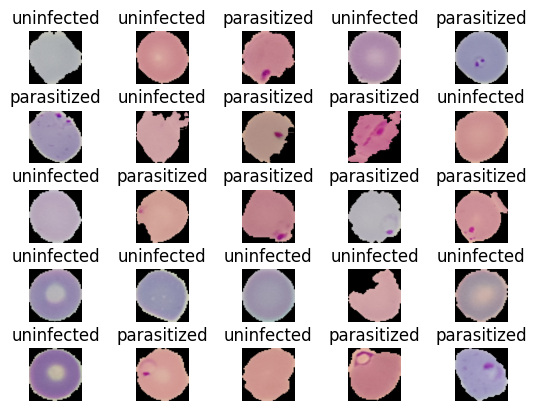

In [13]:
fig = plt.figure()

for i, (image, label) in enumerate(train_dataset.take(25)):
  plt.subplot(5,5, i+1)
  plt.imshow(image)
  plt.title(dataset_set.features['label'].int2str(label))
  plt.axis('off')

# Adjust the space between the plots
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [14]:
BATCH_SIZE = 32

test_dataset = test_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Convolutional Neural Network

In [15]:
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [22]:
# Partial Implementation of LeNet CNN

cnn = tf.keras.Sequential([
     InputLayer(input_shape = (IMAGE_SIZE, IMAGE_SIZE,3), batch_size=32),

     Conv2D(filters=6, kernel_size= 5, activation="relu"),
     BatchNormalization(),
     MaxPooling2D(pool_size=(2, 2), strides=2),

     Conv2D(filters=16, kernel_size= 5, activation="relu"),
     MaxPooling2D(pool_size=(2, 2), strides=2),
     BatchNormalization(),

     Flatten(),
     Dense(100, activation="relu"),
     BatchNormalization(),
     Dense(10, activation="relu"),
     BatchNormalization(),
     Dense(1, activation="sigmoid"),
])

print(cnn.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (32, 220, 220, 6)         456       
                                                                 
 batch_normalization_4 (Bat  (32, 220, 220, 6)         24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (32, 110, 110, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (32, 106, 106, 16)        2416      
                                                                 
 max_pooling2d_3 (MaxPoolin  (32, 53, 53, 16)          0         
 g2D)                                                            
                                                      

In [23]:
cnn.compile(optimizer=Adam(learning_rate=0.01), loss=BinaryCrossentropy(), metrics='accuracy')

In [24]:
# history = cnn.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=1)
with tf.device('/gpu:0'):
  history = cnn.fit(train_dataset, validation_data=val_dataset,epochs=20, verbose=1)

Epoch 1/20
689/689 [==============================] - 49s 65ms/step - loss: 0.3411 - accuracy: 0.8521 - val_loss: 0.4886 - val_accuracy: 0.8642
Epoch 2/20
689/689 [==============================] - 44s 63ms/step - loss: 0.1991 - accuracy: 0.9344 - val_loss: 0.2963 - val_accuracy: 0.9187
Epoch 3/20
689/689 [==============================] - 45s 66ms/step - loss: 0.1860 - accuracy: 0.9378 - val_loss: 1.2835 - val_accuracy: 0.5031
Epoch 4/20
689/689 [==============================] - 44s 64ms/step - loss: 0.1597 - accuracy: 0.9475 - val_loss: 0.1960 - val_accuracy: 0.9506
Epoch 5/20
689/689 [==============================] - 55s 80ms/step - loss: 0.1460 - accuracy: 0.9512 - val_loss: 0.1373 - val_accuracy: 0.9543
Epoch 6/20
689/689 [==============================] - 48s 70ms/step - loss: 0.1393 - accuracy: 0.9521 - val_loss: 0.3579 - val_accuracy: 0.8327
Epoch 7/20
689/689 [==============================] - 44s 64ms/step - loss: 0.1316 - accuracy: 0.9545 - val_loss: 0.1430 - val_accuracy:

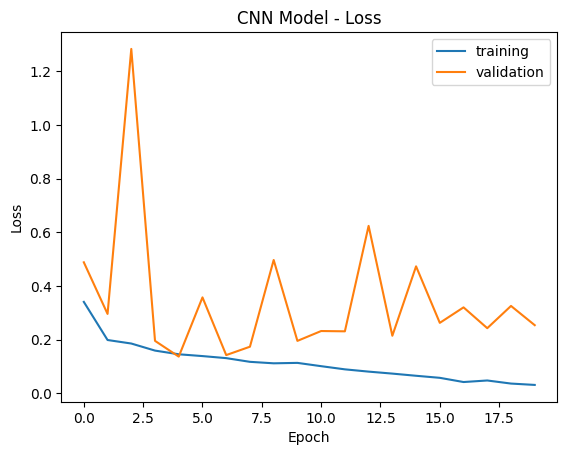

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

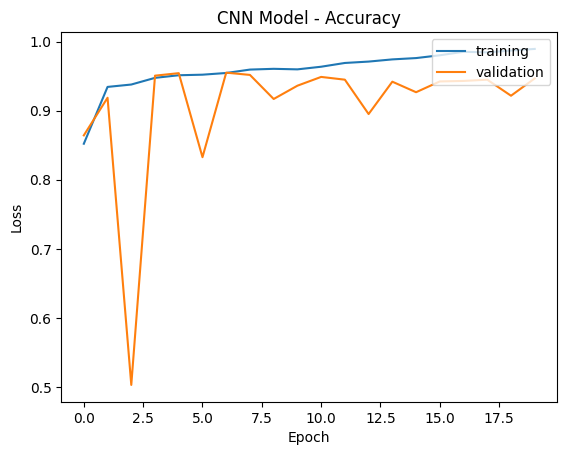

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [27]:
cnn.evaluate(test_dataset)

87/87 [==============================] - 14s 34ms/step - loss: 0.2603 - accuracy: 0.9416


[0.26025980710983276, 0.9415608048439026]